In [1]:
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt

# nb max de clients est 130
n_clients=50
def data_prep(n_clients):
    n_depot = n_clients+1
    #on importe les donnée sur les clients et le depot
    df=pd.read_excel("2_detail_table_customers.xls")
    df_depot=pd.read_excel('4_detail_table_depots.xls')
    #on extrait les informations qui nous intéressent
    Columns=["CUSTOMER_NUMBER","CUSTOMER_LATITUDE","CUSTOMER_LONGITUDE"]
    Data =( df[Columns]
           .rename(columns={"CUSTOMER_NUMBER":"number","CUSTOMER_LATITUDE":"x","CUSTOMER_LONGITUDE":"y"})
          )
    Data=Data.head(n_clients)
    depot = df_depot[['DEPOT_CODE','DEPOT_LATITUDE','DEPOT_LONGITUDE']].drop_duplicates()
    depot = depot.rename(columns={"DEPOT_CODE":"number of client/depot","DEPOT_LATITUDE":"x","DEPOT_LONGITUDE":"y"})
    Data.loc[len(Data)]=depot.iloc[0]
    return Data
def client_distances(Data):
    #définition d'une matrice U qui contient les distances entre les clienst/depot
    U=np.zeros((len(Data),len(Data)))
    for i in range(len(Data)):
        for j in range(i+1,len(Data)):
            U[i,j]=np.sqrt((Data.iloc[i,1]-Data.iloc[j,1])**2+(Data.iloc[i,2]-Data.iloc[j,2])**2)
            U[j,i]=U[i,j]
    return U
Data=data_prep(n_clients)
U=client_distances(Data)

In [2]:
nbmax = 200  # Nombre maximal d'itérations
f_limite = 0  # Borne inférieure de la fonction objectif
taille_max_T = 10  # Taille maximale de la liste taboue

def fonction_objectif( L,M=U):
    time=0
    V=30
    for i in range(len(L)-1):
        time+=U[L[i]-1,L[i+1]-1]
    return time

def generer_voisins(solution,n_voisins=50):
    voisins = []
    n=len(solution)
    # Exemple : génération de voisins en inversant deux éléments de la solution
    #for i in range(1,len(solution)//2):
     #       voisin = solution[:]
     #       voisin[i], voisin[n-i-1] = voisin[n-i-1], voisin[i]
      #      voisins.append(voisin)
    for i in range(n_voisins):
            voisin = solution[1:-1]
            random.shuffle(voisin)
            voisin=[solution[0]]+voisin+[solution[0]]
            voisins.append(voisin)
    
    return voisins
def fonction_aspiration(voisins,T,A):
    # Vérifier si la solution est taboue et satisfait l'aspiration
    sol=voisins[0][:]
    for solution in voisins[1:]:
        if (solution in T)  and (fonction_objectif(solution)<fonction_objectif(sol)):
            sol=solution[:]
    
    #T.remove(sol)
    return sol

def initialiser_solution(n=n_clients+1):
    L=[n]
    aux=[i for i in range(1,n-1)]
    random.shuffle(aux)
    L.extend(aux)
    L.append(n)
    return L


def tabou( sol, nbmax):
    # Initialisation
    solution=sol
    if sol==None:
        solution = initialiser_solution()
    #print(solution)
    meilleure_solution = solution[:]
    nb_iter = 0
    T = []  # Liste taboue initialement vide
    meilleure_iteration = 0
    f_limite = 50

    # Initialisation de la fonction d'aspiration
    A = fonction_objectif(meilleure_solution)
    T.append(solution)
    # Processus itératif
    while (fonction_objectif(solution) > 1) and (nb_iter - meilleure_iteration < nbmax):
    
        nb_iter += 1
        voisins = generer_voisins(solution)
        
        meilleure_voisin = solution[:]
        #print(meilleure_voisin)
        test=False
        for voisin in voisins:
            #print(fonction_objectif(meilleure_voisin))
            if (voisin not in T) and (fonction_objectif(voisin) <= A) and (fonction_objectif(voisin) <= fonction_objectif(meilleure_voisin)) :
                meilleure_voisin = voisin[:]
                test=True
        
        if test==False:
            #print(True)
            # Si aucun voisin valide n'est trouvé, continuer avec la prochaine itération
            meilleure_voisin=fonction_aspiration(voisins,T,fonction_objectif(meilleure_voisin))    
        # Mettre à jour la meilleure solution trouvée
        if fonction_objectif(meilleure_voisin) < fonction_objectif(meilleure_solution):
            meilleure_solution = meilleure_voisin[:]
            meilleure_iteration = nb_iter
        # Mettre à jour la liste taboue
        T.append(meilleure_voisin)
        if len(T) > taille_max_T:
            T.pop(0)  # Supprimer le plus ancien élément de T
        # Mettre à jour la fonction d'aspiration
        A = fonction_objectif(meilleure_solution)
        # Mettre à jour la solution courante
        solution = meilleure_voisin[:]
    #print(A)
    return A,meilleure_solution


In [3]:
nbmax = 300  # Nombre maximal d'itérations
taille_max_T = 10  # Taille maximale de la liste taboue

DEPOT = (Data.iloc[-1]['x'], Data.iloc[-1]['y'])
client_positions = list(zip(Data['x'], Data['y']))


In [4]:
nb_iter=100
A,best_solution=tabou(None,nbmax)
for i in range(nb_iter):
    A_aux,best_solution_aux=tabou(best_solution,nbmax)
    if A>A_aux:
        best_solution=best_solution_aux[:]
        A=A_aux
A

11.450406714051551

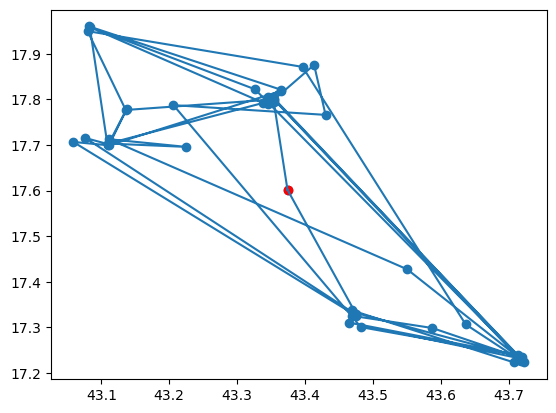

In [5]:
#new_cities_order = np.concatenate((np.array([Data.loc[best_solution[i]-1,['x','y']] for i in range(len(best_solution))]),np.array([Data.loc[n_clients,['x','y']]])))
# Plot the cities.
plt.scatter(Data['x'],Data['y'])
plt.scatter(*DEPOT, color='red', label='Dépôt')
# Plot the path.
X=[Data.loc[i-1,'x'] for i in best_solution]
Y=[Data.loc[i-1,'y'] for i in best_solution]
plt.plot(X,Y)
plt.show()

In [22]:
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector

In [39]:
class OptTabuAgent(Agent):
    def __init__(self, unique_id, model, collaboratif=True):
        super().__init__(unique_id, model)        
        self.sol = initialiser_solution()
        self.best = self.model.fonction_objectif_agent(self.sol)  # Initialiser avec la fonction objectif de la solution initiale
        self.collaboratif=collaboratif
        self.voisins=generer_voisins(self.sol)
        self.T = []
        self.A = self.model.fonction_objectif_agent(self.sol)
        self.meilleure_solution = self.sol[:]
        

    def contact(self):
        min=self.best
        for a in self.model.schedule.agents:
            if a.best<min:
                min=a.best
                best_agent=a
                self.best = a.best  
                self.meilleure_solution = a  # Mettre à jour la meilleure solution

            # Informer le modèle de la nouvelle meilleure solution
            self.model.update_min_solution(self.best, self.meilleure_solution)
            
    #passser d'une itération à une autre
    def step(self):
        self.T.append(self.sol)
        if self.collaboratif==True:
            self.contact()
            
        meilleure_voisin = self.sol[:]
        #print(meilleure_voisin)
        test=False
        for voisin in self.voisins:
            #print(fonction_objectif(meilleure_voisin))
            if (voisin not in self.T) and (self.model.fonction_objectif_agent(voisin) <= self.A) and (self.model.fonction_objectif_agent(voisin) <= self.model.fonction_objectif_agent(meilleure_voisin)) :
                meilleure_voisin = voisin[:]
                test=True
        
        if test==False:
            #print(True)
            meilleure_voisin=self.model.fonction_aspiration(self)    
        # Mettre à jour la meilleure solution trouvée
        if self.model.fonction_objectif_agent(meilleure_voisin) < self.best:
            self.meilleure_solution = meilleure_voisin[:]
            self.best = self.model.fonction_objectif_agent(meilleure_voisin)
        # Mettre à jour la liste taboue
        self.T.append(meilleure_voisin)
        if len(self.T) > taille_max_T:
            self.T.pop(0)  # Supprimer le plus ancien élément de T
        # Mettre à jour la fonction d'aspiration
        self.A = self.model.fonction_objectif_agent(self.meilleure_solution)
        # Mettre à jour la solution courante
        
        self.sol = meilleure_voisin[:]
        print(f"je suis l'agent collab d'id {self.unique_id} et ma meilleure solution est {self.meilleure_solution}")

In [40]:
class TabuModel(Model):
    def fonction_objectif_agent(self, L):
        time = 0
        for i in range(len(L) - 1):
            time += U[L[i] - 1, L[i + 1] - 1]
        return time

    def update_min_solution(self, new_value, new_solution):
        if new_value < self.best_function_value:
            self.best_function_value = new_value
            self.best_solution = new_solution
            
    def fonction_aspiration(self,agent):
    # Vérifier si la solution est taboue et satisfait l'aspiration
        sol=agent.T[0]
        for s in agent.T[1:]:
            if (agent.meilleure_solution!=s)  and (self.fonction_objectif(s)<self.fonction_objectif(sol)):
                sol=s[:]
        agent.T.remove(sol)
        return sol
    
    #le constructeur
    def __init__(self,NC=10, NNC=10):
        self.num_agents_collab=NC
        self.num_agents_non_collab=NNC
        self.best_solution = None
        self.best_function_value = float('inf')  # Initialiser avec l'infini
        
        super().__init__()
        self.schedule=SimultaneousActivation(self) #ajout chef orchestre
        
        #ajout d'un datacollector
        self.datacollector = DataCollector(agent_reporters = {"Temps minimal trouvé" : "best"})        

        #ajout des premiers agents au SMA
        for i in range(NC):
            a = OptTabuAgent(i, self)
            self.schedule.add(a)
            
        for i in range(NNC):
            a = OptTabuAgent(i+NC, self, False)
            self.schedule.add(a)

    def step(self):
        self.schedule.step() 
        self.datacollector.collect(self)

#test du modèle
steps=10
monSMA = TabuModel(10,10)
for i in range(steps):
    print(f"l'instant {i+1}")
    monSMA.step()
    
data = monSMA.datacollector.get_model_vars_dataframe()

# Affiche la courbe
import matplotlib.pyplot as plt
plt.plot(data)

l'instant 1


TypeError: 'OptTabuAgent' object is not subscriptable

In [32]:
len(initialiser_solution())

51

In [ ]:
def fonction_objectif(self,M=U):
        # Calculer le temps total en fonction des solutions des agents collaboratifs et non collaboratifs
        time = 0
        V = 30
        for i in range(len(self.sol) - 1):
            time += U[self.sol[i] - 1, self.sol[i + 1] - 1]
        for i in range(len(self.sol) - 1):
            time += U[self.sol[i] - 1, self.sol[i + 1] - 1]
        return time
        

In [ ]:
        
class OptimisationCollaborativeModel(Model):
    """A model for infection spread."""

    def __init__(self, population, N=6, popSize=100, eliteSize=20, mutationRate=0.01):

        self.population = population
        self.num_agents = N
        self.popSize = popSize
        self.eliteSize = eliteSize
        self.mutationRate = mutationRate
        
        
        
        #The scheduler
        self.schedule = SimultaneousActivation(self)
        
        
        
        
        
        # Create agents
        for i in range(int(self.num_agents/2)):
            a = OptGenAgent(i, self)
            self.schedule.add(a)
            
        for i in range(int(self.num_agents/2),self.num_agents):
            a = OptGenAgent(i, self,True)
            self.schedule.add(a)            
        
        self.datacollector = DataCollector(
            #model_reporters={"TheGlobalBest": compute_global_best},
            agent_reporters={"Best": lambda a:a.best})

            
    
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        



generations=500


cityList = []

for i in range(0,25):
    cityList.append(Point(x=int(random.random() * 200), y=int(random.random() * 200)))
    
model = OptimisationCollaborativeModel(cityList)

for i in range(generations):
    print(f"Génération n{i+1}")
    model.step()  
    

agent_state = model.datacollector.get_agent_vars_dataframe()
print(agent_state)
res=agent_state.unstack()
print(res)
res.plot()
print("la meilleure valeur trouvée : ")
print(res.min().min())